In [2]:
!pip install pandas numpy matplotlib seaborn plotly geopandas




[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: C:\Users\Ravitheja\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [3]:
import pandas as pd

# 1. Load CSV (replace path if needed)
df = pd.read_csv("raw_aqi_full.csv", parse_dates=["last_update"], dayfirst=True, low_memory=False)

# 2. Quick checks
print("Rows:", len(df))
print("Columns:", df.columns.tolist())
print("Unique timestamps:", df["last_update"].nunique(), "example:", df["last_update"].unique()[:5])
print("Unique stations:", df["station"].nunique())
print(df.head(8))

# 3. Missing values per column
print("\nMissing values:")
print(df.isna().sum())



Rows: 3382
Columns: ['country', 'state', 'city', 'station', 'last_update', 'latitude', 'longitude', 'pollutant_id', 'pollutant_min', 'pollutant_max', 'pollutant_avg']
Unique timestamps: 1 example: <DatetimeArray>
['2025-11-11 18:00:00']
Length: 1, dtype: datetime64[ns]
Unique stations: 510
  country  state        city                                station  \
0   India  Bihar     Katihar           Mirchaibari, Katihar - BSPCB   
1   India  Bihar  Kishanganj  SDM Office_Khagra, Kishanganj - BSPCB   
2   India  Bihar  Kishanganj  SDM Office_Khagra, Kishanganj - BSPCB   
3   India  Bihar  Kishanganj  SDM Office_Khagra, Kishanganj - BSPCB   
4   India  Bihar   Manguraha   Forest Rest House, Manguraha - BSPCB   
5   India  Bihar   Manguraha   Forest Rest House, Manguraha - BSPCB   
6   India  Bihar   Manguraha   Forest Rest House, Manguraha - BSPCB   
7   India  Bihar    Motihari        Gandak Colony, Motihari - BSPCB   

          last_update   latitude  longitude pollutant_id  pollutant_m

In [4]:
df = df.dropna(subset=["pollutant_avg"])
print("After dropping missing pollutant_avg:", len(df))


After dropping missing pollutant_avg: 3159


In [5]:
# fix numeric conversions
df["pollutant_avg"] = pd.to_numeric(df["pollutant_avg"], errors="coerce")
df["latitude"] = pd.to_numeric(df["latitude"], errors="coerce")
df["longitude"] = pd.to_numeric(df["longitude"], errors="coerce")


In [6]:
# Normalize strings
str_cols = ["country","state","city","station","pollutant_id"]
for c in str_cols:
    df[c] = df[c].astype(str).str.strip()  # remove extra spaces
df["pollutant_id"] = df["pollutant_id"].str.upper()  # uppercase for consistency
print("Cleaned dataset shape:", df.shape)
df.head(5)

Cleaned dataset shape: (3159, 11)


,country,state,city,station,last_update,latitude,longitude,pollutant_id,pollutant_min,pollutant_max,pollutant_avg
0,India,Bihar,Katihar,"Mirchaibari, Katihar - BSPCB",2025-11-11 18:00:00,25.560083,87.553265,NO2,16.0,18.0,16.0
1,India,Bihar,Kishanganj,"SDM Office_Khagra, Kishanganj - BSPCB",2025-11-11 18:00:00,26.088130,87.938403,NO2,9.0,11.0,10.0
2,India,Bihar,Kishanganj,"SDM Office_Khagra, Kishanganj - BSPCB",2025-11-11 18:00:00,26.088130,87.938403,SO2,6.0,7.0,7.0
3,India,Bihar,Kishanganj,"SDM Office_Khagra, Kishanganj - BSPCB",2025-11-11 18:00:00,26.088130,87.938403,CO,16.0,21.0,19.0
4,India,Bihar,Manguraha,"Forest Rest House, Manguraha - BSPCB",2025-11-11 18:00:00,27.308328,84.531742,PM10,45.0,214.0,96.0


In [7]:
# Step 3: Aggregate to station-level summary

# 1. Mean pollutant value across all pollutants per station
agg_mean = (
    df.groupby(["country", "state", "city", "station",
                "latitude", "longitude", "last_update"], as_index=False)
      ["pollutant_avg"]
      .mean()
      .rename(columns={"pollutant_avg": "pollutant_avg_mean"})
)

# 2. Dominant pollutant per station (the one with max pollutant_avg)
idx = df.groupby("station")["pollutant_avg"].idxmax()
dominant = (
    df.loc[idx, ["station", "pollutant_id", "pollutant_avg"]]
      .rename(columns={"pollutant_id": "dominant_pollutant",
                       "pollutant_avg": "dominant_value"})
)

# 3. Merge mean + dominant pollutant info
station_summary = agg_mean.merge(dominant, on="station", how="left")

# 4. Rank stations by mean pollution (descending)
station_summary["rank"] = (
    station_summary["pollutant_avg_mean"]
        .rank(method="dense", ascending=False)
        .astype(int)
)

# 5. Sort by rank and preview top 10
station_summary = station_summary.sort_values("pollutant_avg_mean",
                                               ascending=False).reset_index(drop=True)

print("Stations summarized:", len(station_summary))
station_summary.head(10)


Stations summarized: 504


,country,state,city,station,latitude,longitude,last_update,pollutant_avg_mean,dominant_pollutant,dominant_value,rank
0,India,Delhi,Delhi,"IGI Airport (T3), Delhi - IMD",28.562776,77.118005,2025-11-11 18:00:00,252.500000,PM10,400.0,1
1,India,Delhi,Delhi,"North Campus, DU, Delhi - IMD",28.657381,77.158545,2025-11-11 18:00:00,234.800000,PM2.5,442.0,2
2,India,Delhi,Delhi,"Burari Crossing, Delhi - IMD",28.725650,77.201157,2025-11-11 18:00:00,227.000000,PM2.5,442.0,3
3,India,Delhi,Delhi,"Pusa, Delhi - IMD",28.636110,77.173332,2025-11-11 18:00:00,214.200000,PM2.5,435.0,4
4,India,Delhi,Delhi,"Aya Nagar, Delhi - IMD",28.470691,77.109936,2025-11-11 18:00:00,214.000000,PM2.5,411.0,5
5,India,Delhi,Delhi,"CRRI Mathura Road, Delhi - IMD",28.551201,77.273574,2025-11-11 18:00:00,207.000000,PM2.5,452.0,6
6,India,Delhi,Delhi,"R K Puram, Delhi - DPCC",28.563262,77.186937,2025-11-11 18:00:00,188.833333,PM2.5,449.0,7
7,India,Delhi,Delhi,"Lodhi Road, Delhi - IMD",28.591825,77.227307,2025-11-11 18:00:00,188.600000,PM2.5,410.0,8
8,India,Delhi,Delhi,"Sonia Vihar, Delhi - DPCC",28.710508,77.249485,2025-11-11 18:00:00,188.500000,PM2.5,435.0,9
9,India,Haryana,Gurugram,"NISE Gwal Pahari, Gurugram - IMD",28.422681,77.148944,2025-11-11 18:00:00,187.400000,PM2.5,397.0,10


In [8]:
# Step 4: Quick Exploratory Checks

import pandas as pd

# 1️⃣ Top 10 stations (already printed, but let's keep only key columns)
top10 = station_summary[["rank","station","city","state","pollutant_avg_mean","dominant_pollutant"]].head(10)
print("Top 10 Most Polluted Stations in India (Snapshot):")
display(top10)

# 2️⃣ State-level averages
state_avg = (
    station_summary.groupby("state", as_index=False)["pollutant_avg_mean"]
                   .mean()
                   .sort_values("pollutant_avg_mean", ascending=False)
)
print("\nTop 10 Most Polluted States (by station average):")
display(state_avg.head(10))

# 3️⃣ Pollutant dominance counts
pollutant_counts = (
    station_summary["dominant_pollutant"]
                   .value_counts()
                   .reset_index()
                   .rename(columns={"index": "Pollutant", "dominant_pollutant": "Count"})
)
print("\nDominant Pollutant Distribution:")
display(pollutant_counts)


Top 10 Most Polluted Stations in India (Snapshot):


,rank,station,city,state,pollutant_avg_mean,dominant_pollutant
0,1,"IGI Airport (T3), Delhi - IMD",Delhi,Delhi,252.500000,PM10
1,2,"North Campus, DU, Delhi - IMD",Delhi,Delhi,234.800000,PM2.5
2,3,"Burari Crossing, Delhi - IMD",Delhi,Delhi,227.000000,PM2.5
3,4,"Pusa, Delhi - IMD",Delhi,Delhi,214.200000,PM2.5
4,5,"Aya Nagar, Delhi - IMD",Delhi,Delhi,214.000000,PM2.5
5,6,"CRRI Mathura Road, Delhi - IMD",Delhi,Delhi,207.000000,PM2.5
6,7,"R K Puram, Delhi - DPCC",Delhi,Delhi,188.833333,PM2.5
7,8,"Lodhi Road, Delhi - IMD",Delhi,Delhi,188.600000,PM2.5
8,9,"Sonia Vihar, Delhi - DPCC",Delhi,Delhi,188.500000,PM2.5
9,10,"NISE Gwal Pahari, Gurugram - IMD",Gurugram,Haryana,187.400000,PM2.5



Top 10 Most Polluted States (by station average):


,state,pollutant_avg_mean
6,Delhi,166.772100
8,Haryana,88.664204
26,Uttar_Pradesh,84.306918
21,Rajasthan,72.182434
14,Madhya Pradesh,71.057035
9,Himachal Pradesh,68.714286
7,Gujarat,67.736032
28,West_Bengal,60.675325
20,Punjab,58.576786
18,Odisha,58.470588



Dominant Pollutant Distribution:


,Count,count
0,PM2.5,226
1,PM10,208
2,OZONE,44
3,CO,19
4,NO2,4
5,SO2,3


C:\Users\Ravitheja\AppData\Local\Temp\ipykernel_11644\3046001040.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


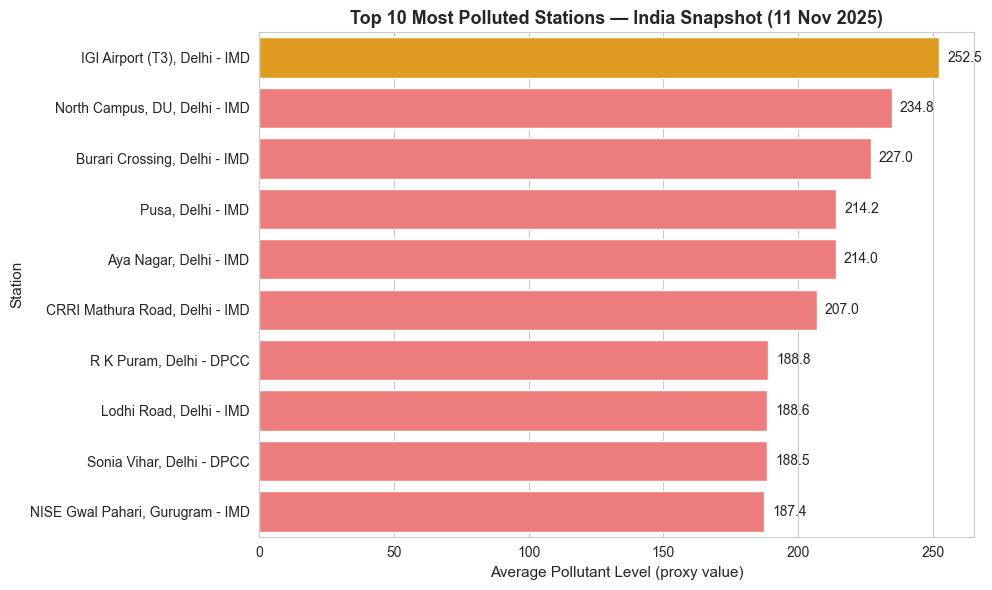

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Correct order: Highest pollution first (rank 1 at top)
top10 = station_summary.head(10).copy()
top10 = top10.sort_values("pollutant_avg_mean", ascending=False)  # now top-down

plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Color differentiation (PM2.5 = red, PM10 = orange)
palette = ["#FF6B6B" if x == "PM2.5" else "#FFA500" for x in top10["dominant_pollutant"]]

sns.barplot(
    y="station",
    x="pollutant_avg_mean",
    data=top10,
    palette=palette,
    order=top10["station"]  # preserve our manual order
)

plt.title("Top 10 Most Polluted Stations — India Snapshot (11 Nov 2025)", fontsize=13, weight="bold")
plt.xlabel("Average Pollutant Level (proxy value)", fontsize=11)
plt.ylabel("Station", fontsize=11)

# Add labels inside bars
for index, value in enumerate(top10["pollutant_avg_mean"]):
    plt.text(value + 3, index, f"{value:.1f}", va='center')

plt.tight_layout()
plt.savefig("top10_polluted_stations_descending.png", dpi=200)
plt.show()


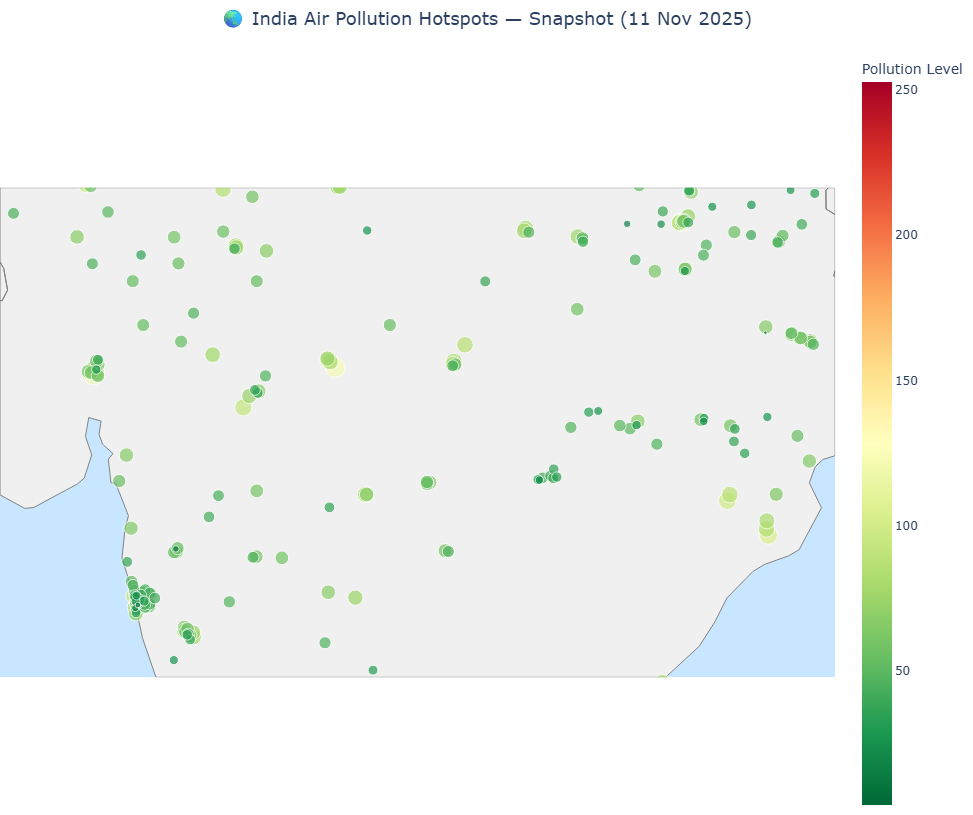

In [12]:
import plotly.express as px

# Create enhanced scatter_geo map
fig = px.scatter_geo(
    station_summary,
    lat="latitude",
    lon="longitude",
    color="pollutant_avg_mean",
    size="pollutant_avg_mean",
    hover_name="station",
    hover_data={
        "city": True,
        "state": True,
        "dominant_pollutant": True,
        "pollutant_avg_mean": ":.1f"
    },
    projection="natural earth",
    title="🌏 India Air Pollution Hotspots — Snapshot (11 Nov 2025)",
    color_continuous_scale="RdYlGn_r",
    opacity=0.7  # transparent circles for overlapping clarity
)

# 🧭 Focus on India region
fig.update_geos(
    scope="asia",
    projection_scale=8.5,  # zoom closer
    center={"lat": 22.0, "lon": 79.0},  # center of India
    showland=True,
    landcolor="rgb(240, 240, 240)",
    showcountries=True,
    countrycolor="gray",
    showframe=False,
    showocean=True,
    oceancolor="rgb(200, 230, 255)",
)

# 🗺️ Add borders for Indian states (approx)
# Plotly has no state shapefile by default, so we mimic outlines with subtle grid lines
fig.update_geos(showlakes=False, lakecolor="LightBlue", showrivers=False)

# ✨ Layout polish
fig.update_layout(
    title_font_size=18,
    title_x=0.5,
    geo=dict(bgcolor="rgba(0,0,0,0)"),
    coloraxis_colorbar=dict(title="Pollution Level"),
    height=800,  # taller map
    width=1000,  # wider for visibility
    margin={"r":0,"t":50,"l":0,"b":0},
)

# ✅ Save both HTML & PNG (if kaleido installed)
fig.write_html("india_aqi_map_enhanced.html")

try:
    fig.write_image("india_aqi_map_enhanced.png", scale=2)
except Exception as e:
    print("PNG export skipped — Kaleido not installed:", e)

fig.show()


C:\Users\Ravitheja\AppData\Local\Temp\ipykernel_11644\2185390862.py:3: DeprecationWarning:

*density_mapbox* is deprecated! Use *density_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/



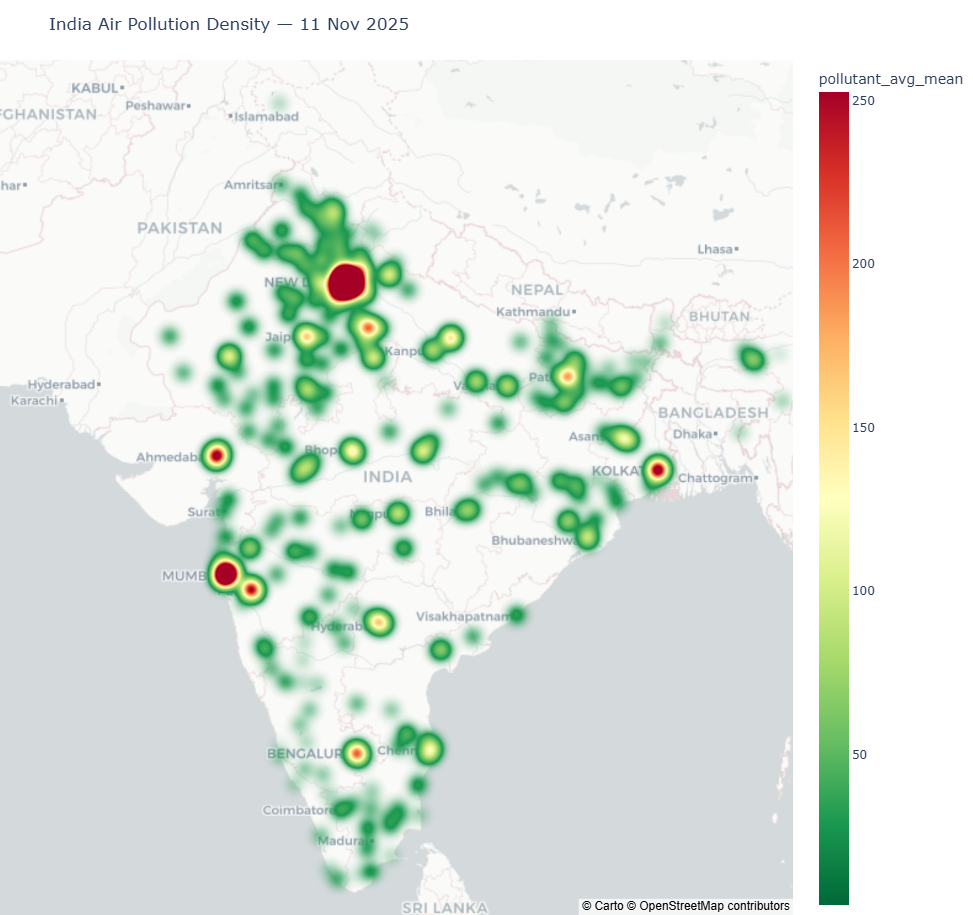

In [15]:
import plotly.express as px

fig = px.density_mapbox(
    station_summary,
    lat="latitude",
    lon="longitude",
    z="pollutant_avg_mean",
    radius=20,                 
    center={"lat":22, "lon":79},
    zoom=4.3,
    mapbox_style="carto-positron",
    color_continuous_scale="RdYlGn_r",
    title="India Air Pollution Density — 11 Nov 2025"
)

# 🔹 make it appear larger
fig.update_layout(
    height=900,       # increase vertical space
    width=1100,       # increase horizontal space
    margin=dict(l=0, r=0, t=60, b=0)
)

fig.show()
